In [1]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

class LSUNBedroomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Traverse the directory to get image paths
        for subdir, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

path = '../Dataset/bedroom/'
# Create dataset
dataset = LSUNBedroomDataset(root_dir='../Dataset/bedroom/', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
len(dataset)

303125

torch.Size([3, 64, 64])


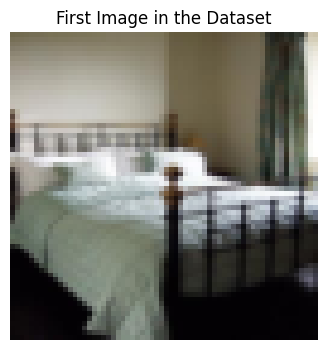

In [3]:
import matplotlib.pyplot as plt

image_tensor = dataset[0]
print(image_tensor.shape)
image = transforms.ToPILImage()(image_tensor)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.title("First Image in the Dataset")
plt.show()

In [5]:
model = UNet2DModel(
    sample_size=64,  # the target image resolution
    in_channels=3,    # the number of input channels, 3 for RGB images
    out_channels=3,   # the number of output channels
    layers_per_block=1,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D")
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
device = torch.device("mps")
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, kernel_si

In [6]:
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        batch = batch.to(device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()
        noise = torch.randn_like(batch)
        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noise_pred = model(noisy_images, timesteps).sample
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed. Loss: {loss.item()}")

Training Epoch 1/20:   0%|          | 0/4737 [00:00<?, ?it/s]

/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Training Epoch 1/20: 100%|██████████| 4737/4737 [33:55<00:00,  2.33it/s]


Epoch 1 completed. Loss: 0.012974544428288937


Training Epoch 2/20: 100%|██████████| 4737/4737 [33:25<00:00,  2.36it/s]


Epoch 2 completed. Loss: 0.009326906874775887


Training Epoch 3/20: 100%|██████████| 4737/4737 [33:23<00:00,  2.36it/s]


Epoch 3 completed. Loss: 0.008448895998299122


Training Epoch 4/20: 100%|██████████| 4737/4737 [33:24<00:00,  2.36it/s]


Epoch 4 completed. Loss: 0.013031660579144955


Training Epoch 5/20: 100%|██████████| 4737/4737 [33:23<00:00,  2.36it/s]


Epoch 5 completed. Loss: 0.009147443808615208


Training Epoch 6/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 6 completed. Loss: 0.011435309424996376


Training Epoch 7/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 7 completed. Loss: 0.009331179782748222


Training Epoch 8/20: 100%|██████████| 4737/4737 [33:23<00:00,  2.36it/s]


Epoch 8 completed. Loss: 0.01693902350962162


Training Epoch 9/20: 100%|██████████| 4737/4737 [33:23<00:00,  2.36it/s]


Epoch 9 completed. Loss: 0.006862532813102007


Training Epoch 10/20: 100%|██████████| 4737/4737 [33:23<00:00,  2.36it/s]


Epoch 10 completed. Loss: 0.0033069343771785498


Training Epoch 11/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 11 completed. Loss: 0.005579718854278326


Training Epoch 12/20: 100%|██████████| 4737/4737 [33:23<00:00,  2.36it/s]


Epoch 12 completed. Loss: 0.0046150279231369495


Training Epoch 13/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 13 completed. Loss: 0.023502277210354805


Training Epoch 14/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 14 completed. Loss: 0.012924512848258018


Training Epoch 15/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 15 completed. Loss: 0.013259694911539555


Training Epoch 16/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 16 completed. Loss: 0.006817397195845842


Training Epoch 17/20: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]


Epoch 17 completed. Loss: 0.004250362515449524


Training Epoch 18/20: 100%|██████████| 4737/4737 [33:20<00:00,  2.37it/s]


Epoch 18 completed. Loss: 0.007717492524534464


Training Epoch 19/20: 100%|██████████| 4737/4737 [33:18<00:00,  2.37it/s]


Epoch 19 completed. Loss: 0.03319559618830681


Training Epoch 20/20: 100%|██████████| 4737/4737 [33:15<00:00,  2.37it/s]

Epoch 20 completed. Loss: 0.007117701694369316


In [7]:
# Save the model
torch.save(model.state_dict(), "ddpm_bedroom_64x64_20_epoch.pth")

In [ ]:
# Load the model
# model.load_state_dict(torch.load("ddpm_bedroom_1_epoch.pth"))

In [8]:
import os
import torch
from tqdm import tqdm
from torchvision.utils import save_image

model.eval()
num_images = 50
generated_images = []

with torch.no_grad():
    for _ in tqdm(range(num_images), desc="Generating Images"):
        noisy_image = torch.randn(1, 3, 64, 64, device=device)
        for t in reversed(range(noise_scheduler.num_train_timesteps)):
            timesteps = torch.full((1,), t, device=device, dtype=torch.long)
            model_output = model(noisy_image, timesteps)
            
            step_result = noise_scheduler.step(model_output.sample, t, noisy_image)
            noisy_image = step_result.prev_sample
        
        generated_image = noisy_image.squeeze(0).cpu()
        generated_images.append(generated_image)

# Saving generated images
output_dir = f"generated_images_{num_epochs}_epochs"
os.makedirs(output_dir, exist_ok=True)

for idx, image in enumerate(generated_images):
    save_image(image, f"{output_dir}/generated_image_{idx+1}.png")

print(f"{num_images} images generated and saved in {output_dir}")

Generating Images: 100%|██████████| 50/50 [09:51<00:00, 11.82s/it]

50 images generated and saved in generated_images_20_epochs


In [9]:
model.eval()

num_images = 50
generated_images = []

with torch.no_grad():
    for _ in tqdm(range(num_images), desc="Generating Images"):
        noisy_image = torch.randn(1, 3, 32, 32, device=device)
        for t in reversed(range(noise_scheduler.config.num_train_timesteps)):  # Access via config
            timesteps = torch.full((1,), t, device=device, dtype=torch.long)
            model_output = model(noisy_image, timesteps)
            
            step_result = noise_scheduler.step(model_output.sample, t, noisy_image)
            noisy_image = step_result.prev_sample
        
        generated_image = noisy_image.squeeze(0).cpu()
        generated_images.append(generated_image)

# Saving generated images
output_dir = f"generated_images_64x64{num_epochs}_epochs"
os.makedirs(output_dir, exist_ok=True)

for idx, image in enumerate(generated_images):
    save_image(image, f"{output_dir}/generated_image_64x64{idx+1}.png")

print(f"{num_images} images generated and saved in {output_dir}")

Generating Images: 100%|██████████| 50/50 [09:24<00:00, 11.29s/it]

50 images generated and saved in generated_images_64x6420_epochs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

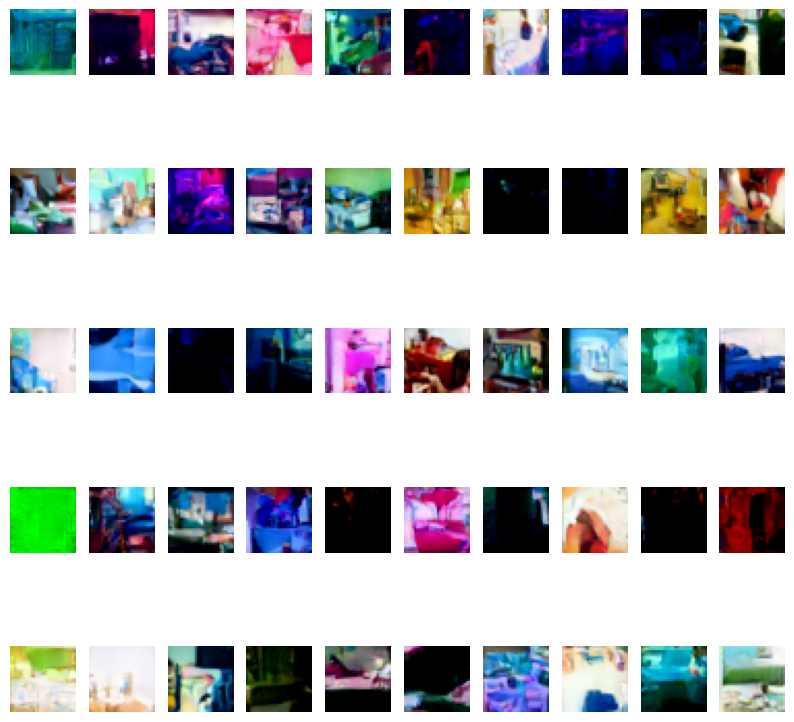

In [10]:
# plot 50 images from the generated images
plt.figure(figsize=(10, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(generated_images[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()